In [41]:
import igl
import math
import scipy as sp
import numpy as np
import meshplot as mp
import pandas as pd
import matplotlib.pyplot as plt
import numba
import os
root_folder = os.getcwd()

In [42]:

v, f = igl.read_triangle_mesh(os.path.join(root_folder, "restart_2.off"))### Read The Final Mesh Here


v_init, f = igl.read_triangle_mesh(os.path.join(root_folder, "equilibrated.off") ) ### Read The Initial Mesh Here                         

In [43]:
max(v_init[0:,2])

0.978532236968276

In [44]:
p=mp.plot(v,f,shading={"wireframe":True, "wire_color": "black", #Wireframerendering   
                               "width": 300, "height": 300},return_plot=True) ###Viewing The Mesh

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0040892…

[]

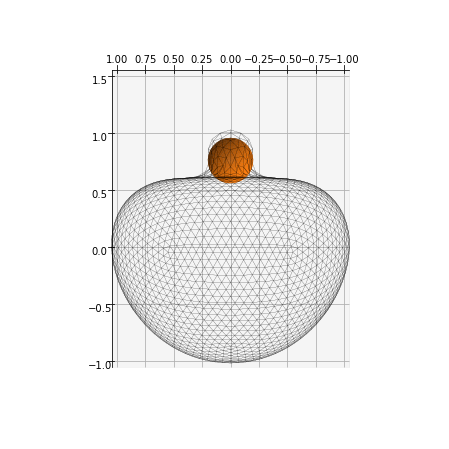

In [45]:
#Mesh with particl
rp=0.20
rho=0.1*rp
x=np.amax(v_init[:,0])-rp-1*rho
y=0
z=0
fig = plt.figure(figsize =(14, 8))
ax = plt.axes(projection ='3d')
surf=ax.plot_trisurf(v[:,0], v[:,1], v[:,2], triangles = f, edgecolor=[[0,0,0]], linewidth=0.05, alpha=0.0, shade=False)
u, v1 = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x1 = (rp*(np.cos(u) * np.sin(v1)))+x
y1 = (rp*(np.sin(u) * np.sin(v1)))
z1 = (rp*(np.cos(v1)))
surf=ax.plot_surface(x1, y1, z1)
ax.view_init(90,180)
ax = plt.gca()
ax.set_xlim([-1, 1.5])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_proj_type('ortho')
ax.set_box_aspect((xmax-xmin, ymax-ymin,ymax-ymin))
ax.set_zticks([])

In [ ]:
a=igl.avg_edge_length(v,f)
a

In [ ]:
def cal_volumetot(v,f):
    Volumetot = 0
    for i in range(len(f)):
        sum=0
        p0x=v[f[i][0]][0]
        p0y=v[f[i][0]][1]
        p0z=v[f[i][0]][2]
        p1x=v[f[i][1]][0]
        p1y=v[f[i][1]][1]
        p1z=v[f[i][1]][2]
        p2x=v[f[i][2]][0]
        p2y=v[f[i][2]][1]
        p2z=v[f[i][2]][2]
        v321= p2x*p1y*p0z
        v231= p1x*p2y*p0z
        v312= p2x*p0y*p1z
        v132= p0x*p2y*p1z
        v213= p1x*p0y*p2z
        v123= p0x*p1y*p2z
        sum=(-v321+ v231+ v312-v132-v213+ v123) / 6.0
        #print(sum)
        Volumetot+=sum
    return Volumetot


In [ ]:
### To chech the initial and final volume
Volume_Final= cal_volumetot(v,f)
Volume_new=cal_volumetot(v_init,f1)
print(Volume_new)
Volume_Final/Volume_new

In [ ]:
Kb=0.01
H0=0
def Force_Bending(v,f):
    npv = igl.per_vertex_normals(v, f)
    K = igl.gaussian_curvature(v, f)
    m = igl.massmatrix(v, f, igl.MASSMATRIX_TYPE_VORONOI)
    minv = sp.sparse.diags(1 / m.diagonal())
    area_voronoi=m.diagonal()
    l = igl.cotmatrix(v, f) ###laplacian-operator
    Hn = -minv.dot(l.dot(v))/2
    H_mean = np.linalg.norm(Hn, axis=1)
    sign_H = np.sign(np.sum(Hn*npv, axis=1))
    H_mean_signed = H_mean*sign_H
    Lap_H = minv.dot(l.dot(H_mean_signed-H0))
    kn = minv.dot(K)
    first_term = 2*(H_mean_signed-H0)*(H_mean_signed**2 + H0*H_mean_signed -kn)
    totalforce = first_term + Lap_H
    Force_bending = 2*Kb*npv*totalforce[:,None]*area_voronoi[:,None]

    Eb = 2*Kb*(((H_mean_signed-H0)**2))*area_voronoi
    total_EB = np.sum(Eb)
        
    return Force_bending,total_EB

In [ ]:
### To check the bending energy of the vesicle
force,energy=Force_Bending(v,f)
energy

In [ ]:
# with open('logfile_1.txt','r') as f: ###Give the file name here
#     Energy1=[]
#     string='Total Energy' ### Name it as the which energy term you want 
#     for line in f:
#         if string in line:
#             Energy1.append(float(line.split(': ')[1]))
# print(Energy1)

In [ ]:
with open('logfile.txt','r') as f: ###Give the file name here
    BiasedEnergy=[]
    string='Biased Energy' ### Name it as the which energy term you want 
    for line in f:
        if string in line:
            BiasedEnergy.append(float(line.split(': ')[1]))
print(BiasedEnergy)

In [ ]:
###To read an Energy contribution from the logfile

with open('logfile.txt','r') as f: ###Give the file name here
    BendingEnergy=[]
    string='Bending Energy' ### Name it as the which energy term you want 
    for line in f:
        if string in line:
            BendingEnergy.append(float(line.split(': ')[1]))
print(BendingEnergy)
len(BendingEnergy)

In [ ]:

with open('logfile.txt','r') as f: ###Give the file name here
    AdhesionEnergy=[]
    string='Adhesion Energy' ### Name it as the which energy term you want 
    for line in f:
        if string in line:
            AdhesionEnergy.append(float(line.split(': ')[1]))
print(AdhesionEnergy)

In [ ]:

with open('logfile.txt','r') as f: ###Give the file name here
    VolumeEnergy=[]
    string='Volume Energy' ### Name it as the which energy term you want 
    for line in f:
        if string in line:
            VolumeEnergy.append(float(line.split(': ')[1]))
print(VolumeEnergy)

In [ ]:
with open('logfile.txt','r') as f: ###Give the file name here
    TotalEnergy=[]
    string='Total Energy' ### Name it as the which energy term you want 
    for line in f:
        if string in line:
            TotalEnergy.append(float(line.split(': ')[1]))
print(TotalEnergy)

In [ ]:
number_of_iterations=np.arange(0,len(TotalEnergy),1)
number_of_iterations=number_of_iterations*100


In [ ]:
b=TotalEnergy1+TotalEnergy
c=AdhesionEnergy1+AdhesionEnergy

In [ ]:
###Plotting Energy Contribution with resrpect to number of iterations
import matplotlib as mpl
mpl.rcParams['figure.dpi']=400
plt.plot(number_of_iterations,BendingEnergy,'bo-',label='Bending Energy')
plt.plot(number_of_iterations,AdhesionEnergy,'g<-',label='Adhesion Energy')
plt.plot(number_of_iterations,TotalEnergy,'rs-',label='Total Energy')
plt.plot(number_of_iterations,VolumeEnergy,'y<-',label='Volume Energy')
plt.plot(number_of_iterations,BiasedEnergy,'k.-',label='Biased Energy')
csfont={'fontname':'Times New Roman'}
plt.xlabel('Number of Iterations',**csfont)
plt.ylabel('Energy of the System',fontsize=12,**csfont)
plt.title('Inside_Particle_u=2.1,rp=0.15,K_biased=1.0')
plt.legend(loc='upper right')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
Wrapping_Fraction=np.array([0.2165,0.31,0.35,0.47,0.70,0.70,0.70501,0.71,0.72,0.707])
Wrapping_Fraction_2=np.array([0.2521,0.3814,0.41,0.621,0.6421,0.6503,0.65557,0.6591,0.66,0.6626])
Rescaled_Adhesion_Strength=np.array([1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5])
import matplotlib as mpl
mpl.rcParams['figure.dpi']=300
plt.plot(Rescaled_Adhesion_Strength,Wrapping_Fraction,'bo--',label='Particle Radius=0.15')
plt.plot(Rescaled_Adhesion_Strength,Wrapping_Fraction_2,'g<-.',label='Particle Radius=0.20')
csfont={'fontname':'Times New Roman'}
plt.xlabel('Rescaled Adhesion strength',**csfont)
plt.ylabel('Wrapping Fraction',fontsize=12,**csfont)
#plt.xlim((0.5, 5.5))
plt.xticks(np.arange(1.0, 6.0, step=0.5)) 
plt.yticks(np.arange(0.1, 0.9, step=0.1)) 
##plt.title('Inside_Particle_u=2.1,rp=0.15,K_biased=1.0')
plt.legend(loc='right')

In [ ]:
Total_Energy=float(input('Total_Energy:'))
Bending_Energy=float(input('Bedning_Energy:'))
Adhesin_Energy=float(input('Adhesion_Energy:'))

In [ ]:
u=2.0
Kb=0.01
Rp=0.20
U=(u*Kb)/Rp**2
Wrapping_Fraction=Adhesin_Energy/(U*4*np.pi*(Rp**2)) 
print(Wrapping_Fraction)

In [ ]:
Wrapping_Fraction_biased_rc_2=0.5798094154309293
Bending_Energy_Biased_rc_2=np.array([0.308214])/(8*np.pi*Kb)
Total_Energy_Biased_rc_2=np.array([0.209404])/(8*np.pi*Kb)

In [ ]:
Wrapping_Fraction_biased_pr_002=[0.0665,0.068651086,] 
Bending_Energy_Biased_pr_002=np.array([0.253447,0.25372,])/(8*np.pi*Kb)
Total_Energy_Biased_pr_002=np.array([0.242275,0.254494])/(8*np.pi*Kb)

In [ ]:
Wrapping_Fraction_biased_rv=[0.2597,0.2801,0.3303,0.3867,0.44483,0.47550,0.5742,0.66468276770826] 
Bending_Energy_Biased_rv=np.array([0.262238,0.26745,0.276612,0.28697,0.296698,0.305981,0.328935,0.366627])/(8*np.pi*Kb)
Total_Energy_Biased_rv=np.array([0.205022,0.199078,0.193912,0.189848,0.18589,0.191411,0.189645,0.217144])/(8*np.pi*Kb)

In [ ]:
wrapping_fracction_non_biased=Total_Energy_non_biased

In [ ]:
import pandas as pd
data = pd.read_csv("Insider_Particle_Energy.csv")
wrapping_fracction=np.array(data.iloc[:,0])
total_energy=np.array(data.iloc[:,1])

In [ ]:
data = pd.read_csv("Insider_Particle_Bending_Energy.csv")
wrapping_fracction_1=np.array(data.iloc[:,0])
bending_energy=np.array(data.iloc[:,1])

In [ ]:
Wrapping_Fraction_non_biased=Wrapping_Fraction
Total_Energy_non_biased=Total_Energy/(8*np.pi*Kb)

In [ ]:
Wrapping_Fraction_biased=[0.28636430600638546,0.33054094356040287,0.3515084136506869,0.40699102047459484,
                          0.47778711803544716,0.5510700115821104,0.6138208267696674,0.6356728004561846] 
Bending_Energy_Biased=np.array([0.268309,0.276072,0.28307,0.294741,0.309794,0.329768,0.349815,0.363786])/(8*np.pi*Kb)
Total_Energy_Biased=np.array([0.23316,0.223246,0.22058,0.214318,0.205676,0.202518,(0.205564+0.00234569), 0.220175])/(8*np.pi*Kb)

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']=300
plt.plot(wrapping_fracction_1,bending_energy,'b--',label='Theoretical')
plt.plot(Wrapping_Fraction_biased,Bending_Energy_Biased,'s',label='u=2.0_biased_with_volume_constraint')
plt.plot(Wrapping_Fraction_biased_rv,Bending_Energy_Biased_rv,'<',label='u=2.0_biased_withour_volume_constraint')
plt.plot(Wrapping_Fraction_biased_rc_2,Bending_Energy_Biased_rc_2,'o',label='cut_off_range=2*potential_range')
#plt.plot(Rescaled_Adhesion_Strength,Wrapping_Fraction_2,'g<-.',label='Particle Radius=0.20')
csfont={'fontname':'Times New Roman'}
plt.ylabel('Bending Energy/ 8*pi*Kb',**csfont)
plt.xlabel('Wrapping Fraction',fontsize=12,**csfont)
#plt.xlim((0.5, 5.5))
plt.xticks(np.arange(0.0, 1.0, step=0.1)) 
# plt.yticks(np.arange(0.1, 0.9, step=0.1)) 
##plt.title('Inside_Particle_u=2.1,rp=0.15,K_biased=1.0')
plt.legend(loc='upper left')

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']=300
plt.plot(wrapping_fracction,total_energy,'bo--',label='Theoretical')
plt.plot(Wrapping_Fraction_biased_rv,Total_Energy_Biased_rv,'X',label='Biased')
#plt.plot(0.41165823918076466,Total_Energy_non_biased,'s',label='Non_Biased')
#plt.plot(Rescaled_Adhesion_Strength,Wrapping_Fraction_2,'g<-.',label='Particle Radius=0.20')
csfont={'fontname':'Times New Roman'}
plt.ylabel('Total Energy/8*pi*Kb',**csfont)
plt.xlabel('Wrapping Fraction',fontsize=12,**csfont)
#plt.xlim((0.5, 5.5))
plt.xticks(np.arange(0.0, 1.0, step=0.1)) 
# plt.yticks(np.arange(0.1, 0.9, step=0.1)) 
##plt.title('Inside_Particle_u=2.1,rp=0.15,K_biased=1.0')
plt.legend(loc='right')

In [ ]:
Total_Energy_Biased=0.205676/(8*np.pi*Kb)